In [9]:
import cv2
import csv
import numpy as np
import sklearn
from sklearn.utils import shuffle
import math
from skimage.util import random_noise


65241
-1.0


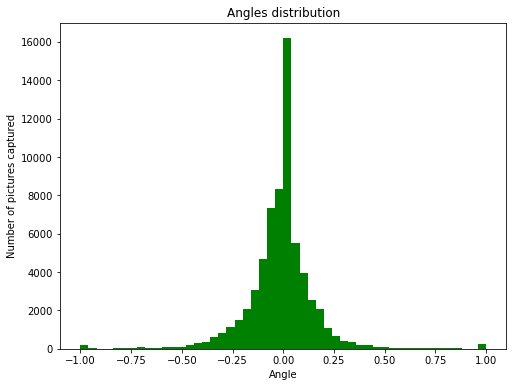

In [10]:
angles = []
with open('examples/sample_data/data/my_data/log_data_0_1_2_3_4_5_6_7_8_9_10.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(csvfile)
    for row in reader:
        if (row[3]!= 'steering'):
            angles.append(float(row[3]))
print(len(angles))
angles = np.array(angles)
print(min(angles))
import matplotlib.pyplot as plt
# define window size, output and axes
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Angles distribution")

# set x-axis name
ax.set_xlabel("Angle")

# set y-axis name
ax.set_ylabel("Number of pictures captured")

# create histogram within output
N, bins, patches = ax.hist(angles, bins=50, color="green") #initial color of all bins


In [4]:
lines = []

abs_steering_min = 0.1 # 0.1
correction = 0.2 # this is a parameter to tune

with open('examples/sample_data/data/my_data/log_data_0_1_2_3_4_5_6_7_8_9_10.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(csvfile)
    for row in reader:
        if (row[3]!= 'steering' and math.fabs(float(row[3])) > abs_steering_min):
            lines.append(row)
def add_noise(image):
    #var = random.uniform(0.01, 0.02)
    return random_noise(image, mode='gaussian', var=0.001)  

print('lines:' + str(len(lines)))
        
from sklearn.model_selection import train_test_split
shuffle(lines)
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

FIRST_TURN_PROBLEM_FOLDER = 'delta_0'
FIRST_TURN_PROBLEM_FOLDER1= 'delta_8'

def get_images_angles(batch_samples):
    images = []
    angles = []
    for line in batch_samples:
        central_path = line[0]
        central_image = get_image(central_path, False)
        left_path = line[1]
        left_image = get_image(left_path, False)
        right_path =  line[2]
        right_image = get_image(right_path, False)
        images.extend([central_image, left_image, right_image])
        steering_center = float(line[3])        
        steering_left = steering_center + correction
        steering_right = steering_center - correction
        angles.extend([steering_center, steering_left, steering_right])
        fliped_central_image, fliped_central_angle = flip_image(central_image,steering_center)
        fliped_left_image, fliped_left_angle = flip_image(left_image,steering_left)
        fliped_right_image, fliped_right_angle = flip_image(right_image,steering_right) 
        if FIRST_TURN_PROBLEM_FOLDER in central_path or FIRST_TURN_PROBLEM_FOLDER1 in central_path \
            or math.fabs(steering_center) > 0.2:
            for i in range(5):
                noised_image = add_noise(central_image)
                images.append(noised_image)
                angles.append(steering_center)
            for i in range(5):
                noised_image = add_noise(right_image)
                images.append(noised_image)
                angles.append(steering_right)      
            for i in range(5):
                noised_image = add_noise(left_image)
                images.append(noised_image)
                angles.append(steering_left)
            for i in range(5):
                noised_image = add_noise(fliped_central_image)
                images.append(noised_image)
                angles.append(fliped_central_angle)
        images.extend([fliped_central_image, fliped_left_image, fliped_right_image])
        angles.extend([fliped_central_angle, fliped_left_angle, fliped_right_angle])
        return (images, angles)



def get_image(path, resize=False, yuv=True):
    filename = path.split("/")[-1]
    current_path = '/home/carnd/CarND-Behavioral-Cloning-P3/examples/sample_data/data/my_data/IMG/' + filename
    image = cv2.imread(current_path)
    if yuv:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    #if resize:
    #    image = cv2.resize(image,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
    return image

def flip_image(image, angle):
    return (cv2.flip(image, 1), angle*-1.0)

def generator(lines, batch_size=32):
    num_samples = len(lines)
    while 1: # Loop forever so the generator never terminates
        shuffle(lines)
        for offset in range(0, num_samples, batch_size):
            batch_samples = lines[offset:offset+batch_size]
            images, angles = get_images_angles(batch_samples)  
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

                


lines:23071


(160, 320, 3)
-0.1795401
(160, 320, 3)


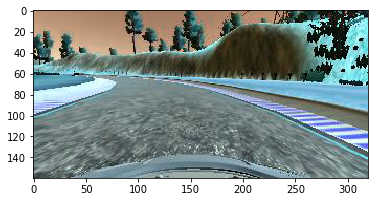

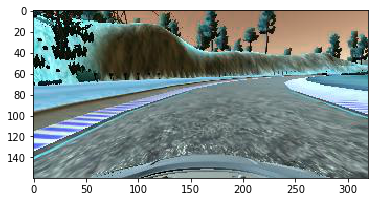

(65, 320, 3)


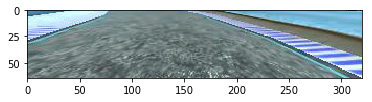

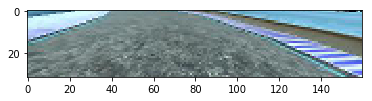

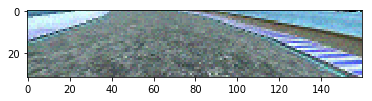

(32, 160, 3)


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
line = lines [0]
central_path = line[0]
central_image = get_image(central_path, yuv= False)
print(central_image.shape)
print(line[3])
steering_center = float(line[3])
image = np.array(central_image)
#y_train = np.array(augmented_measurements)
print(image.shape)
plt.imshow(image)
plt.show()
flipped_image = flip_image(central_image, float(line[3]) )
plt.imshow(flipped_image[0])
plt.show()
cropped = image[70:135, 0:320]
print(cropped.shape)
plt.imshow(cropped)
plt.show()
resized_image =  cv2.resize(cropped,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
plt.imshow(resized_image)
plt.show()
noised_image=add_noise(resized_image)
plt.imshow(noised_image)
plt.show()
print(resized_image.shape)



In [6]:
print(len(train_samples))
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)
from keras.backend import tf as ktf
def resize_normalize_grey(image, grey=False):
    import tensorflow as tf
    #resize 
    resized = tf.image.resize_images(image, (30, 160))
    #normalize
    if grey :
        resized = tf.image.rgb_to_grayscale(resized)
    resized = resized/255.0 - 0.5
    return resized


18456


In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D, Input, Dropout
from keras.backend import tf as ktf
model = Sequential()
model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape = (160,320,3)))
model.add(Lambda(resize_normalize_grey))#, output_shape=(30, 160, 3)))

#Nvidia model

model.add(Convolution2D(24,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Convolution2D(36,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Dropout(0.2))
model.add(Convolution2D(48,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Dropout(0.2))
model.add(Convolution2D(64,1,1,border_mode='valid', activation='relu', subsample=(1,1)))
model.add(Dropout(0.2))
model.add(Convolution2D(64,1,1,border_mode='valid', activation='relu', subsample=(1,1)))
model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='tanh'))

model.compile(loss = 'mse', optimizer='adam', lr=0.01)
model.fit_generator(train_generator, samples_per_epoch= len(train_samples), \
                    validation_data=validation_generator, \
            nb_val_samples=len(validation_samples), nb_epoch=3, verbose = 1)
model.save('model.h5')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1917: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/3
18456/18456 [==============================] - 215s - loss: 0.0954 - val_loss: 0.1021
Epoch 2/3
18456/18456 [==============================] - 216s - loss: 0.0864 - val_loss: 0.1039
Epoch 3/3
18446/18456 [============================>.] - ETA: 0s - loss: 0.0835

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


18472/18456 [==============================] - 216s - loss: 0.0835 - val_loss: 0.1035
